In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
from IPython.display import display

In [2]:
os.chdir("..")

## Load Results

In [27]:
schemes = ["fullsample", "splitsample", "onfolds"]
models = ["plr", "irm"]
learners = ["Lasso", "Random Forest", "XGBoost", "FLAML", "LinearModels"]
scenarios = range(16)
oracle_df = pd.read_csv("simulations/results/oracle.csv", delimiter=";")
df = pd.DataFrame(columns=["DGP", "model", "learner", "scheme", "coef", "confint", "bias"])
res = []
for sc in scenarios:
    true_theta = oracle_df.loc[oracle_df.DGPid==(sc+1),"psi0.ATE"].values[0]
    oracle_mse = oracle_df.loc[oracle_df.DGPid==(sc+1),"MSE"].values[0]
    for model in models:
        for learner in learners:
            if learner == "LinearModels":
                schemes = ["fullsample"]
            else: 
                schemes = ["fullsample", "splitsample", "onfolds"]
            for scheme in schemes:
                paths = {
                    "Lasso": f"simulations/results/acic_v2/{model}/LassoCV/Scenario{sc+1}_LassoCV_{scheme}.csv",
                    "Random Forest":  f"simulations/results/acic_v2/{model}/RandomForest/Scenario{sc+1}_{scheme}.csv",
                    "XGBoost": f"simulations/results/acic_v2/{model}/XGBoost/Scenario{sc+1}_{scheme}.csv",
                    "FLAML": f"simulations/results/acic_v2/{model}/Scenario{sc+1}/60_{scheme}.csv",
                    "LinearModels": f"simulations/results/acic_v2/{model}/LinearModels/Scenario{sc+1}_LinearModels_{scheme}.csv",
                        }
                load_df = pd.read_csv(paths[learner])
                rep = load_df["Unnamed: 0"]
                coef = load_df["coef"].values
                confint = ((load_df["2.5%"] < true_theta) & (load_df["97.5%"] > true_theta)).astype("int").values
                bias = coef - true_theta
                rbias = bias / np.sqrt(oracle_mse)
                rrmse = np.sqrt(np.mean(np.square(bias))) / np.sqrt(oracle_mse)
                if model == "irm":
                    try:
                        predict_y = load_df["fs_loss_mlg"]
                        comb_loss = load_df["fs_loss_mlg"] * load_df["fs_loss_mlm"]
                    except:
                        predict_y = load_df["fs_loss_mll"]
                        comb_loss = load_df["fs_loss_mll"] * load_df["fs_loss_mlm"]
                if model == "plr":
                    predict_y = load_df["loss_Y"]
                    comb_loss = (load_df["fs_loss_mll"] + load_df["fs_loss_mlm"]) * load_df["fs_loss_mlm"]

                res.append(pd.DataFrame([np.repeat(sc+1,100), rep, np.repeat(model,100),np.repeat(learner,100),np.repeat(scheme,100),
                                         coef, confint, bias, rbias, np.repeat(rrmse,100), predict_y, comb_loss], 
                                         index=["sc", "rep", "model", "learner", "scheme", "coef", "confint", "bias", "rbias", "rrmse", "predict_y", "comb_loss"]).transpose())
df = pd.concat((res))
df["rrmse-1"] = df.rrmse.values -1
schemes = ["fullsample", "splitsample", "onfolds"]
df.head()

,sc,rep,model,learner,scheme,coef,confint,bias,rbias,rrmse,predict_y,comb_loss,rrmse-1
0,1,0,plr,Lasso,fullsample,0.286102,1,0.086102,0.652488,1.095024,4.722745,3.709074,0.095024
1,1,1,plr,Lasso,fullsample,0.33644,1,0.13644,1.033956,1.095024,4.892763,4.057695,0.095024
2,1,2,plr,Lasso,fullsample,0.090525,1,-0.109475,-0.829607,1.095024,5.130473,3.955124,0.095024
3,1,3,plr,Lasso,fullsample,0.370382,1,0.170382,1.291168,1.095024,5.114704,3.96432,0.095024
4,1,4,plr,Lasso,fullsample,0.233294,1,0.033294,0.252303,1.095024,5.559756,4.272133,0.095024


## Figures 11-14 RMSE

In [4]:
df["Scenario"] = df["sc"]
df.loc[df.model=="irm", "Causal Model"] = "IRM"
df.loc[df.model=="plr", "Causal Model"] = "PLR"
df["Bias"] = df["bias"]
df.loc[df.scheme=="fullsample", "Tuning Scheme"] = "Full Sample"
df.loc[df.scheme=="splitsample", "Tuning Scheme"] = "Split Sample"
df.loc[df.scheme=="onfolds", "Tuning Scheme"] = "On Folds"
df["Learner"] = df["learner"]
df["Coverage"] = df.confint
df["rRMSE - 1"] = df.rrmse.values - 1

In [ ]:
for scid in [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]:
    grid = sns.FacetGrid(df.loc[df.Scenario.isin(scid)], col="Causal Model", row="Scenario", sharey="row", height=3, aspect=1.5)
    grid.map(sns.barplot, "Learner", "rRMSE - 1", "Tuning Scheme", order=learners, hue_order=["Full Sample", "Split Sample", "On Folds"], errorbar=None, palette="bright")
    plt.suptitle("Root Mean Squared Error relative to oracle RMSE")
    plt.subplots_adjust(top=0.95, bottom = 0.05)
    plt.legend(["Full Sample", "Split Sample", "On Folds"])
    plt.show()

## Figures 15-18 Bias

In [7]:
def add_hline(y, *args, **kwargs):
    plt.axhline(y=y, linestyle="--", color = "red")

def add_hline2(y, color = "red", *args, **kwargs):
    plt.axhline(y=y, linestyle="--", color = color)


In [ ]:
for scid in [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]:
    grid = sns.FacetGrid(df.loc[df.sc.isin(scid)], col="Causal Model", row="Scenario", sharey="row", height=3, aspect=1.5)
    grid.map(sns.boxplot, "Learner", "Bias", "Tuning Scheme", order=learners, hue_order=["Full Sample", "Split Sample", "On Folds"], palette="bright", showfliers = False)
    grid.map(add_hline, y=0)
    grid.add_legend(loc='lower center', ncol=3)
    grid.set_xticklabels(learners, rotation=30)
    plt.suptitle("Bias of Estimates", x=0.4) 
    plt.subplots_adjust(top=0.95, bottom=0.1)
    plt.show()

## Fig 23-26 Combined Loss

In [ ]:
df["abs_bias"] = np.abs(df["bias"])
df["squared_error"] = np.square(df["bias"])
df_saved = df
df = df_saved.loc[df.Learner != "LinearModels"].copy()
for scid in [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]:
    fig, axs = plt.subplots(4,2,figsize=(13,18))#10, 18 orig.
    axs.flatten()
    for idx, sc in enumerate(scid):
        sns.scatterplot(df.loc[(df.sc==sc) & (df.model=="plr")], x="comb_loss", y="squared_error", hue="Learner", style="Tuning Scheme", ax=axs[idx][0], legend=False)
        if ((sc==8) | (sc==4) | (sc==12) | (sc==16)):
            sns.scatterplot(df.loc[(df.sc==sc) & (df.model=="irm")], x="comb_loss", y="squared_error", hue="Learner", style="Tuning Scheme", ax=axs[idx][1])
        else:
            sns.scatterplot(df.loc[(df.sc==sc) & (df.model=="irm")], x="comb_loss", y="squared_error", hue="Learner", style="Tuning Scheme", ax=axs[idx][1], legend=False)
        axs[idx][0].set_title(f"Scenario {sc}, Model = PLR")
        axs[idx][0].set_xlabel("Combined Loss")
        axs[idx][0].set_ylabel("Absolute Bias")
        x_up = df.loc[(df.sc==sc) & (df.model=="plr")].comb_loss.quantile(0.985)
        x_low = df.loc[(df.sc==sc) & (df.model=="plr")].comb_loss.min()
        x_diff = x_up - x_low
        y_up = df.loc[(df.sc==sc) & (df.model=="plr")].squared_error.quantile(0.985)
        y_low = df.loc[(df.sc==sc) & (df.model=="plr")].squared_error.min()
        y_diff = y_up - y_low
        axs[idx][0].set_xlim((x_low-0.05*x_diff, x_up+0.05*x_diff))
        axs[idx][0].set_ylim((y_low-0.05*y_diff, y_up+0.05*y_diff))

        axs[idx][1].set_title(f"Scenario {sc}, Model = IRM")
        axs[idx][1].set_xlabel("Combined Loss")
        axs[idx][1].set_ylabel("Absolute Bias")
        x_up = df.loc[(df.sc==sc) & (df.model=="irm")].comb_loss.quantile(0.985)
        x_low = df.loc[(df.sc==sc) & (df.model=="irm")].comb_loss.min()
        x_diff = x_up - x_low
        y_up = df.loc[(df.sc==sc) & (df.model=="irm")].squared_error.quantile(0.985)
        y_low = df.loc[(df.sc==sc) & (df.model=="irm")].squared_error.min()
        y_diff = y_up - y_low
        axs[idx][1].set_xlim((x_low-0.05*x_diff, x_up+0.05*x_diff))
        axs[idx][1].set_ylim((y_low-0.05*y_diff, y_up+0.05*y_diff))
    fig.suptitle("Combined Loss vs. Absolute Bias", y=1.0001)
    fig.tight_layout();
df = df_saved;

## Fig 6 - Zoomed In Plot Sc 11

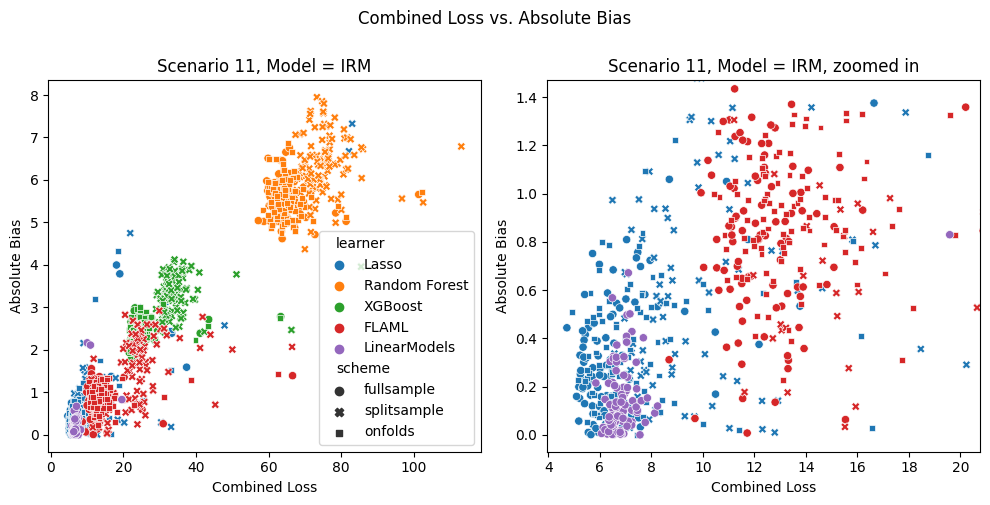

In [19]:
df["abs_bias"] = np.abs(df["bias"])
fig, axs = plt.subplots(1,2,figsize=(10,5))#
sc, model = 11, "irm"
axs.flatten()
sns.scatterplot(df.loc[(df.sc==11) & (df.model==model)], x="comb_loss", y="abs_bias", hue="learner", style="scheme", ax=axs[0])
sns.scatterplot(df.loc[(df.sc==11) & (df.model==model)], x="comb_loss", y="abs_bias", hue="learner", style="scheme", ax=axs[1], legend=False)
axs[0].set_title(f"Scenario 11, Model = IRM")
axs[0].set_xlabel("Combined Loss")
axs[0].set_ylabel("Absolute Bias")

axs[1].set_title(f"Scenario 11, Model = IRM, zoomed in")
axs[1].set_xlabel("Combined Loss")
axs[1].set_ylabel("Absolute Bias")
x_up = 20
x_low = df.loc[(df.sc==sc) & (df.model==model)].comb_loss.min()
x_diff = x_up - x_low
y_up = 1.4
y_low = df.loc[(df.sc==sc) & (df.model==model)].abs_bias.min()
y_diff = y_up - y_low
axs[1].set_xlim((x_low-0.05*x_diff, x_up+0.05*x_diff))
axs[1].set_ylim((y_low-0.05*y_diff, y_up+0.05*y_diff))
fig.suptitle("Combined Loss vs. Absolute Bias", y=1.0001)
fig.tight_layout();

## Fig 19-22 Loss on Y

In [28]:
df["Predictive Performance on Y"] = df.predict_y

In [ ]:
for scid in [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]:
    grid = sns.FacetGrid(df.loc[(df.sc.isin(scid)) & (df.learner!="LinearModels")], col="Causal Model", row="Scenario", sharey="row", height=3, aspect=1.5)
    grid.map(sns.boxplot, "Learner", "Predictive Performance on Y", "Tuning Scheme", order=["Lasso", "Random Forest", "XGBoost", "FLAML"], hue_order=["Full Sample", "Split Sample", "On Folds"], palette="bright", showfliers = False)
    grid.add_legend(loc='lower center', ncol=3)
    plt.suptitle("MSE in the prediction of Y", x=0.4) 
    plt.subplots_adjust(top=0.94, bottom=0.06)
    plt.show()

## Fig 3
Selecting the "true" or "best" Model per DGP, then aggregate over all

In [43]:
best = ["plr","plr","plr","plr","irm","irm","plr","irm","irm","irm","irm","irm","irm","irm","irm","plr"]
_list = []
for idx, model in enumerate(best):
    _list.append(df.loc[(df.sc==idx+1) & (df.model == model) & (df.learner!="LinearModels")])
df_best = pd.concat(_list)
df_best.head()

,sc,rep,model,learner,scheme,coef,confint,bias,rbias,rrmse,...,RRMSE - 1,abs_bias,squared_error,Scenario,Causal Model,Bias,Tuning Scheme,Learner,Coverage,Predictive Performance on Y
0,1,0,plr,Lasso,fullsample,0.286102,1,0.086102,0.652488,1.095024,...,0.095024,0.086102,0.007414,1,PLR,0.086102,Full Sample,Lasso,1,4.722745
1,1,1,plr,Lasso,fullsample,0.33644,1,0.13644,1.033956,1.095024,...,0.095024,0.13644,0.018616,1,PLR,0.13644,Full Sample,Lasso,1,4.892763
2,1,2,plr,Lasso,fullsample,0.090525,1,-0.109475,-0.829607,1.095024,...,0.095024,0.109475,0.011985,1,PLR,-0.109475,Full Sample,Lasso,1,5.130473
3,1,3,plr,Lasso,fullsample,0.370382,1,0.170382,1.291168,1.095024,...,0.095024,0.170382,0.02903,1,PLR,0.170382,Full Sample,Lasso,1,5.114704
4,1,4,plr,Lasso,fullsample,0.233294,1,0.033294,0.252303,1.095024,...,0.095024,0.033294,0.001108,1,PLR,0.033294,Full Sample,Lasso,1,5.559756


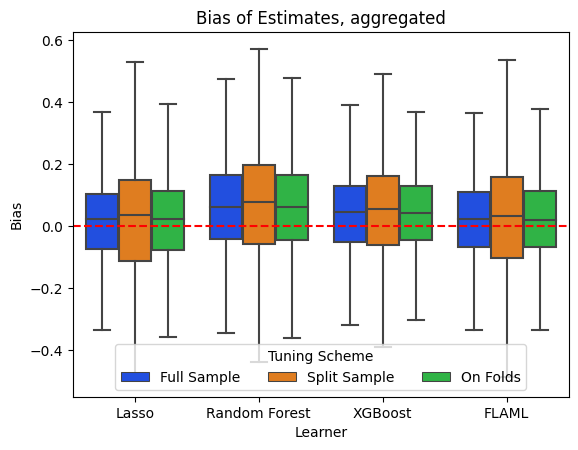

In [45]:
sns.boxplot(df_best, x="learner", y="bias", hue="Tuning Scheme", order=["Lasso", "Random Forest", "XGBoost", "FLAML"], hue_order=["Full Sample","Split Sample","On Folds"], palette="bright", showfliers = False)
plt.axhline(y=0, linestyle="--", color="red")
plt.title("Bias of Estimates, aggregated")
plt.ylabel("Bias")
plt.xlabel("Learner")
plt.legend(title="Tuning Scheme",loc="lower center", ncol=3)
plt.subplots_adjust(top=0.87)

In [50]:
df_best["rRMSE - 1"] = df_best["RRMSE - 1"] 

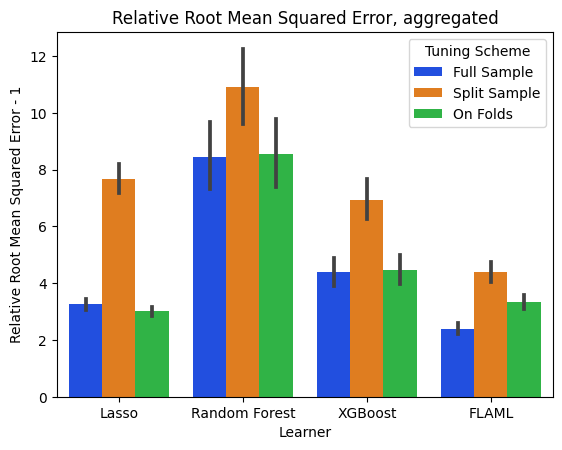

In [52]:
df_best.loc[df_best.scheme=="fullsample","Tuning Scheme"] = "Full Sample"
df_best.loc[df_best.scheme=="splitsample","Tuning Scheme"] = "Split Sample"
df_best.loc[df_best.scheme=="onfolds","Tuning Scheme"] = "On Folds"
sns.barplot(df_best, x="Learner", y="rRMSE - 1", hue="Tuning Scheme", estimator="mean", order=["Lasso", "Random Forest", "XGBoost", "FLAML"], hue_order=["Full Sample","Split Sample","On Folds"], palette="bright")
#plt.axhline(y=0.65, linestyle="--", color="red")
#plt.axhline(y=2.98, linestyle="--", color="blue")
plt.title("Relative Root Mean Squared Error, aggregated")
#plt.legend(["Full Sample", "Split Sample", "On Folds"],title="Tuning Scheme")
plt.ylabel("Relative Root Mean Squared Error - 1")
plt.xlabel("Learner")
plt.subplots_adjust(top=0.87)

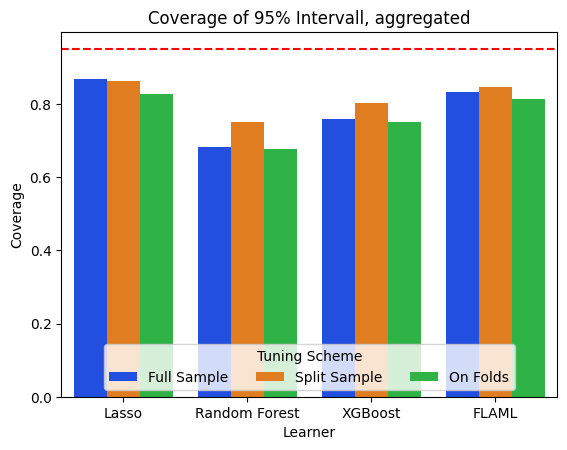

In [55]:
sns.barplot(df_best, x="learner", y="confint", hue="Tuning Scheme", order=["Lasso", "Random Forest", "XGBoost", "FLAML"], hue_order=["Full Sample","Split Sample","On Folds"], palette="bright", errorbar = None)
plt.axhline(y=0.95, linestyle="--", color="red")
plt.title("Coverage of 95% Intervall, aggregated")
plt.ylabel("Coverage")
plt.xlabel("Learner")
plt.subplots_adjust(top=0.87)
plt.legend(title="Tuning Scheme",loc="lower center", ncol=3)

In [ ]:
parameter = "confint"
for model in models:
    output = pd.DataFrame()
    for learner in learners:
        for scheme in schemes:
            output[learner+" "+scheme] = df_grouped.loc[(df_grouped.model == model) & (df_grouped.learner == learner) & (df_grouped.scheme == scheme)].sort_values(by="sc").reset_index()[parameter]
    output.index += 1
    for idx in [[0,1,2,3,4,5], [6,7,8,9,10,11]]:
        print(output.iloc[:,idx].to_latex(header= schemes + schemes, float_format="%.2f"))

## Fig 8 Categories

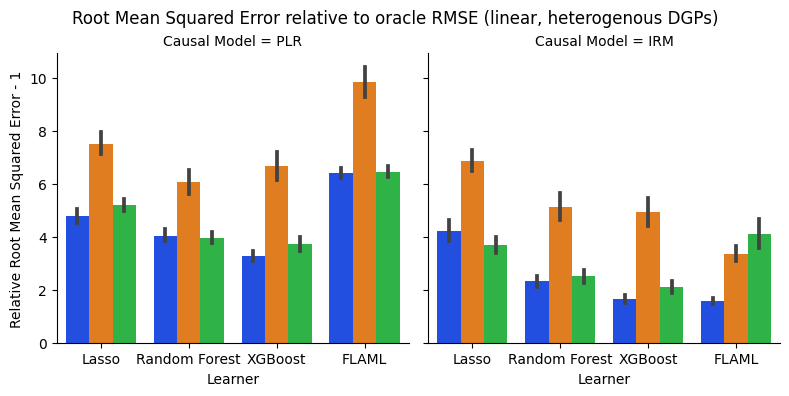

In [59]:
# IRM should work
scenarios = [8,9,10,12,14] #[5,8,9,10,14] # for plr [1,2,3,4,7,16] # for irm [8,9,10,12,14] # for no [13,15,5,6]
df_plot = df.loc[df.sc.isin(scenarios)].copy()
df_plot.loc[df_plot.model=="irm", "Model"] = "IRM"
df_plot.loc[df_plot.model=="plr", "Model"] = "PLR"
grid = sns.FacetGrid(df_plot, col="Causal Model", sharey="row", height=4)
grid.map(sns.barplot, "Learner", "rRMSE - 1", "Tuning Scheme", order=["Lasso", "Random Forest", "XGBoost", "FLAML"], hue_order=["Full Sample","Split Sample","On Folds"], palette="bright")
grid.fig.suptitle("Root Mean Squared Error relative to oracle RMSE (linear, heterogenous DGPs)")
grid.set_xlabels("Learner")
grid.set_ylabels("Relative Root Mean Squared Error - 1")
plt.subplots_adjust(top=0.87)
plt.show()

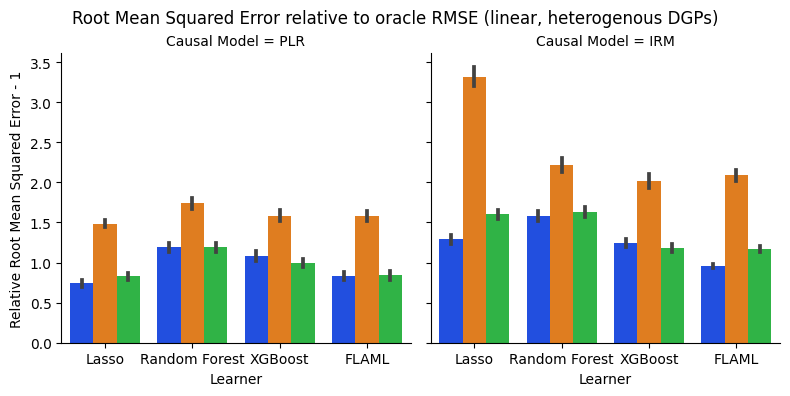

In [60]:
# PLR should work
scenarios = [1,2,3,4,7,16] #[5,8,9,10,14] # for plr [1,2,3,4,7,16] # for irm [8,9,10,12,14] # for no [13,15,5,6]
df_plot = df.loc[df.sc.isin(scenarios)].copy()
df_plot.loc[df_plot.model=="irm", "Model"] = "IRM"
df_plot.loc[df_plot.model=="plr", "Model"] = "PLR"
grid = sns.FacetGrid(df_plot, col="Causal Model", sharey="row", height=4)
grid.map(sns.barplot, "Learner", "rRMSE - 1", "Tuning Scheme", order=["Lasso", "Random Forest", "XGBoost", "FLAML"], hue_order=["Full Sample","Split Sample","On Folds"], palette="bright")
grid.fig.suptitle("Root Mean Squared Error relative to oracle RMSE (linear, heterogenous DGPs)")
grid.set_xlabels("Learner")
grid.set_ylabels("Relative Root Mean Squared Error - 1")
plt.subplots_adjust(top=0.87)
plt.show()

## Table 14 / 15

In [190]:
#df_test = df.loc[(df.sc.isin([8,9,10,12,14])) & (df.scheme=="fullsample")] # for IRM
df_test = df.loc[(df.sc.isin([1,2,3,4,7,16])) & (df.scheme=="fullsample")] # for PLR

In [191]:
c1, c2, c3, c4 = 0,0,0,0
for learner in ["Lasso", "Random Forest", "XGBoost", "FLAML"]:
    for sc in df_test.sc.unique():
        df_temp_irm = df_test.loc[(df_test.learner == learner) & (df_test.sc == sc) & (df_test.model == "irm")].copy().reset_index()
        df_temp_plr = df_test.loc[(df_test.learner == learner) & (df_test.sc == sc) & (df_test.model == "plr")].copy().reset_index()
        for i in range(100):
            if df_temp_irm.iloc[i]["abs_bias"] < df_temp_plr.iloc[i]["abs_bias"]:
                if df_temp_irm.iloc[i]["predict_y"] < df_temp_plr.iloc[i]["predict_y"]:
                    c1+=1
                else:
                    c2+=1
            else:
                if df_temp_irm.iloc[i]["predict_y"] < df_temp_plr.iloc[i]["predict_y"]:
                    c3+=1
                else:
                    c4+=1

In [192]:
sum = c1 + c2 + c3 + c4
print(c1/sum, c2/sum)
print(c3/sum, c4/sum)

0.11916666666666667 0.24416666666666667
0.3025 0.33416666666666667


## Tables for Appendix
Note, to create Tables:
- aggregate `rmmse` .mean() for RRMSE
- aggregate `bias` .mean() for Bias
- aggregate `confint` .mean() for Coverage
- aggregate `coef` .std() for Standard Deviation

*The highlight function needs to be adjusted for Bias and Coverage*

In [185]:
model = "irm"
measure = "confint"

In [181]:
def highlight_min(row):
    row = row.astype(float)
    min_value = (row-0.95).abs().min()
    return pd.Series(['\textbf{{{:.{prec}f}}}'.format(x, prec=4) if np.abs(x-0.95) == min_value else '{:.{prec}f}'.format(x, prec=4) for x in row])

In [167]:
def highlight_min(row):
    row = row.astype(float)
    min_value = row.min()
    return pd.Series(['\textbf{{{:.{prec}f}}}'.format(x, prec=4) if x == min_value else '{:.{prec}f}'.format(x, prec=4) for x in row])

In [186]:
latex_frame = df.loc[df.model==model].groupby(["sc","learner","scheme"])[measure].mean().unstack(["learner","scheme"])
custom_dict = {'FLAML': 0, 'Lasso': 1, 'Random Forest': 2, 'XGBoost': 3, "LinearModels": 4} 
latex_frame.sort_values(by="learner", axis=1, key=lambda x: x.map(custom_dict), inplace=True)
print(latex_frame.apply(highlight_min, axis=1).to_latex(escape=False))

\begin{tabular}{llllllllllllll}
\toprule
{} &               0  &               1  &               2  &               3  &               4  &               5  &      6  &      7  &      8  &               9  &      10 &      11 &               12 \\
sc &                  &                  &                  &                  &                  &                  &         &         &         &                  &         &         &                  \\
\midrule
1  &           0.9800 &           0.9800 &  \textbf{0.9500} &  \textbf{0.9500} &           0.9800 &           0.9400 &  0.9800 &  0.9800 &  0.9900 &           0.9700 &  0.9800 &  0.9900 &           0.9800 \\
2  &           0.8300 &           0.8300 &           0.6600 &           0.8400 &           0.6300 &           0.7800 &  0.4200 &  0.3900 &  0.5500 &           0.6100 &  0.5800 &  0.7000 &  \textbf{0.9700} \\
3  &           0.7600 &           0.7800 &           0.7600 &           0.8200 &           0.5900 &           0.8800 &

C:\Users\BAQ7040\AppData\Local\Temp\ipykernel_19788\3088579348.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(latex_frame.apply(highlight_min, axis=1).to_latex(escape=False))


## Load additional results and challenge results

In [5]:
challenge_results = pd.read_csv("simulations/results/results_challenge.csv").drop(columns=["Unnamed: 0"])
challenge_results = challenge_results.loc[challenge_results["Y.cont"]==1]
for sc in scenarios:
    challenge_results.loc[challenge_results.DGPid==sc+1,"RRMSE"] = challenge_results.loc[challenge_results.DGPid==sc+1,"rMSE"] / np.sqrt(oracle_df.loc[oracle_df.DGPid==(sc+1),"MSE"].values[0])
    challenge_results.loc[challenge_results.DGPid==sc+1,"rel.bias"] = np.abs(challenge_results.loc[challenge_results.DGPid==sc+1,"bias"] / oracle_df.loc[oracle_df.DGPid==(sc+1),"bias"].values[0])
    challenge_results.loc[challenge_results.DGPid==sc+1,"rel.sd"] = np.abs(challenge_results.loc[challenge_results.DGPid==sc+1,"sd"] / oracle_df.loc[oracle_df.DGPid==(sc+1),"sd"].values[0])
challenge_results.head()

,fname,DGPid,Y.cont,bias,rel.bias,sd,rel.sd,rMSE,coverage,CIwidth,RRMSE
0,BCF,1,1,-0.034965,2.347537,0.131869,1.000697,0.135787,1.00,1.400692,1.029002
1,BCF,2,1,0.040453,174.857083,0.071745,1.020620,0.082051,1.00,1.382817,1.173096
2,BCF,3,1,0.165472,5286.638168,0.084949,1.150925,0.185809,0.99,1.021937,2.530110
3,BCF,4,1,0.048455,4.817912,0.057733,1.066800,0.075151,1.00,1.643940,1.371918
4,BCF,5,1,-0.031194,3.996312,0.717823,8.337396,0.714905,1.00,23.860226,8.310915


Load the default (untuned) Results

In [6]:
models = ["plr", "irm"]
learners = ["RF untuned", "XGB untuned"]
scenarios = range(16)
oracle_df = pd.read_csv("simulations/results/oracle.csv", delimiter=";")
res = []
for sc in scenarios:
    true_theta = oracle_df.loc[oracle_df.DGPid==(sc+1),"psi0.ATE"].values[0]
    oracle_mse = oracle_df.loc[oracle_df.DGPid==(sc+1),"MSE"].values[0]
    oracle_bias = oracle_df.loc[oracle_df.DGPid==(sc+1),"bias"].values[0]
    oracle_std = oracle_df.loc[oracle_df.DGPid==(sc+1),"sd"].values[0]
    for model in models:
        for learner in learners:
            paths = {
                "RF untuned": f"simulations/results/acic_v2/{model}/RFdef/Scenario{sc+1}_RandomForestdefault.csv",
                "XGB untuned": f"simulations/results/acic_v2/{model}/XGBdef/Scenario{sc+1}_XGBoostdefault.csv",
                    }
            load_df = pd.read_csv(paths[learner])
            rep = load_df["Unnamed: 0"]
            coef = load_df["coef"].values
            confint = ((load_df["2.5%"] < true_theta) & (load_df["97.5%"] > true_theta)).astype("int").values
            bias = coef - true_theta
            rrmse = np.sqrt(np.mean(np.square(bias))) / np.sqrt(oracle_mse)
            rbias = np.abs(np.mean(coef - true_theta)/oracle_bias)
            rstd = np.std(coef)/oracle_std
            if model == "irm":
                try:
                    predict_y = load_df["fs_loss_mlg"]
                    comb_loss = load_df["fs_loss_mlg"] * load_df["fs_loss_mlm"]
                except:
                    predict_y = load_df["fs_loss_mll"]
                    comb_loss = load_df["fs_loss_mll"] * load_df["fs_loss_mlm"]
            if model == "plr":
                comb_loss = (load_df["fs_loss_mll"] + load_df["fs_loss_mlm"]) * load_df["fs_loss_mlm"]
                try:
                    predict_y = load_df["loss_Y"]
                except:
                    predict_y = np.repeat(np.nan,100)

            res.append(pd.DataFrame([np.repeat(sc+1,100), rep, np.repeat(model,100),np.repeat(learner,100),
                                        coef, confint, bias, np.repeat(rbias,100), np.repeat(rstd,100), np.repeat(rrmse,100), predict_y, comb_loss], 
                                        index=["sc", "rep", "model", "learner", "coef", "confint", "bias", "rbias", "rstd", "rrmse", "predict_y", "comb_loss"]).transpose())
default_df = pd.concat((res))
default_df["rrmse-1"] = default_df.rrmse.values -1
default_df.head()

,sc,rep,model,learner,coef,confint,bias,rbias,rstd,rrmse,predict_y,comb_loss,rrmse-1
0,1,0,plr,RF untuned,0.275805,1,0.075805,0.328216,1.095087,1.094198,NaN,3.98525,0.094198
1,1,1,plr,RF untuned,0.344077,1,0.144077,0.328216,1.095087,1.094198,NaN,4.238201,0.094198
2,1,2,plr,RF untuned,0.077935,1,-0.122065,0.328216,1.095087,1.094198,NaN,4.196909,0.094198
3,1,3,plr,RF untuned,0.44003,1,0.24003,0.328216,1.095087,1.094198,NaN,4.353869,0.094198
4,1,4,plr,RF untuned,0.162769,1,-0.037231,0.328216,1.095087,1.094198,NaN,4.472103,0.094198


## Appendix B: Aggregation strategies

In [7]:
def evaluate_strategy(strategy_df, name):
    scenarios=range(16)
    res = []
    for sc in scenarios:
        true_theta = oracle_df.loc[oracle_df.DGPid==(sc+1),"psi0.ATE"].values[0]
        oracle_mse = oracle_df.loc[oracle_df.DGPid==(sc+1),"MSE"].values[0]
        oracle_bias = oracle_df.loc[oracle_df.DGPid==(sc+1),"bias"].values[0]
        oracle_std = oracle_df.loc[oracle_df.DGPid==(sc+1),"sd"].values[0]
        sub_df = strategy_df.loc[strategy_df.sc==(sc+1)]
        bias = sub_df.coef - true_theta
        res.append([np.sqrt(np.mean(np.square(bias)))/np.sqrt(oracle_mse), np.abs(np.mean(bias)/oracle_bias), sub_df.confint.mean(),sub_df.coef.std()/oracle_std])
    res_strat = pd.DataFrame(res, columns=["RRMSE","rel.bias","coverage","rel.sd"])
    res_strat["DGPid"] = res_strat.index + 1
    res_strat["fname"] = np.repeat(name, 16)
    return res_strat

Strategy 1: Select Model by lower median of `predict_y` (MSE on Y), then select learner / scheme by lowest `comb_loss`

In [8]:
grouped_df1 = df.groupby(['sc', 'rep', 'model']).agg({'predict_y': 'median'}).reset_index()
idx = grouped_df1.groupby(['sc', 'rep'])['predict_y'].idxmin()
filtered_df1 = grouped_df1.loc[idx]
filtered_df1 = filtered_df1.merge(df, on=["sc","rep","model"], validate="one_to_many")
grouped_df2 = filtered_df1.groupby(['sc', 'rep', 'learner', 'scheme','model']).agg({'comb_loss': 'min'}).reset_index()
idx = grouped_df2.groupby(['sc', 'rep'])['comb_loss'].idxmin()
filtered_df2 = grouped_df2.loc[idx]
final_df = pd.merge(filtered_df2.drop(columns=["comb_loss"]), df, on=["sc", "rep", "model", "scheme", "learner"], how="left", validate="one_to_one")
res_strat1 = evaluate_strategy(final_df, "DoubleML")

Do the same without Splitsample

In [9]:
grouped_df1 = df.loc[(df.scheme!="splitsample")].groupby(['sc', 'rep', 'model']).agg({'predict_y': 'median'}).reset_index()
idx = grouped_df1.groupby(['sc', 'rep'])['predict_y'].idxmin()
filtered_df1 = grouped_df1.loc[idx]
filtered_df1 = filtered_df1.merge(df, on=["sc","rep","model"], validate="one_to_many")
grouped_df2 = filtered_df1.groupby(['sc', 'rep', 'learner', 'scheme','model']).agg({'comb_loss': 'min'}).reset_index()
idx = grouped_df2.groupby(['sc', 'rep'])['comb_loss'].idxmin()
filtered_df2 = grouped_df2.loc[idx]
final_df = pd.merge(filtered_df2.drop(columns=["comb_loss"]), df, on=["sc", "rep", "model", "scheme", "learner"], how="left", validate="one_to_one")
res_strat2 = evaluate_strategy(final_df, "No Splitsampe")

Always use FLAML & Fullsample

In [10]:
grouped_df1 = df.loc[(df.scheme=="fullsample") & (df.learner=="FLAML")].groupby(['sc', 'rep', 'model']).agg({'predict_y': 'median'}).reset_index()
idx = grouped_df1.groupby(['sc', 'rep'])['predict_y'].idxmin()
filtered_df1 = grouped_df1.loc[idx]
filtered_df1 = filtered_df1.merge(df, on=["sc","rep","model"], validate="one_to_many")
grouped_df2 = filtered_df1.groupby(['sc', 'rep', 'learner', 'scheme','model']).agg({'comb_loss': 'min'}).reset_index()
idx = grouped_df2.groupby(['sc', 'rep'])['comb_loss'].idxmin()
filtered_df2 = grouped_df2.loc[idx]
final_df = pd.merge(filtered_df2.drop(columns=["comb_loss"]), df, on=["sc", "rep", "model", "scheme", "learner"], how="left", validate="one_to_one")
res_strat3 = evaluate_strategy(final_df, "Only FLAML FS")

Use IRM and default RF

In [11]:
final_df2 = default_df.loc[(default_df.learner=="RF untuned") & (default_df.model=="irm")]
res_strat4 = evaluate_strategy(final_df2, "RF default")

# Causal Models

In [21]:
# we remove linear models because initial analysis was without them
var = "abs_bias"
df["abs_bias"] = df.bias.abs()
cm_df = df.loc[(df.scheme=="fullsample") & (df.learner!="LinearModels")].groupby(["sc","model","rep"])[[var,"predict_y"]].mean().reset_index()
cm_df2 = pd.DataFrame()
cm_df2["Bias Advantage"] = (cm_df.loc[cm_df.model=="irm", var].values - cm_df.loc[cm_df.model=="plr", var].values) / cm_df.loc[cm_df.model=="plr", var].values
cm_df2["Predict Y Advantage"] = (cm_df.loc[cm_df.model=="irm", "predict_y"].values - cm_df.loc[cm_df.model=="plr", "predict_y"].values) / cm_df.loc[cm_df.model=="plr", "predict_y"].values
cm_df2["sc"] = np.repeat(np.arange(1,17,1),100)
cm_df2["rep"] = np.tile(np.arange(1,101,1),16)
cm_df2

,Bias Advantage,Predict Y Advantage,sc,rep
0,0.162389,0.046095,1,1
1,-0.105986,0.066800,1,2
2,0.067133,0.094065,1,3
3,0.157854,0.077333,1,4
4,-0.351811,0.075503,1,5
...,...,...,...,...
1595,-0.066171,0.051978,16,96
1596,0.018693,0.098009,16,97
1597,0.229358,0.068443,16,98
1598,0.097131,0.064277,16,99


Text(0.5, 0, 'DGP ID')

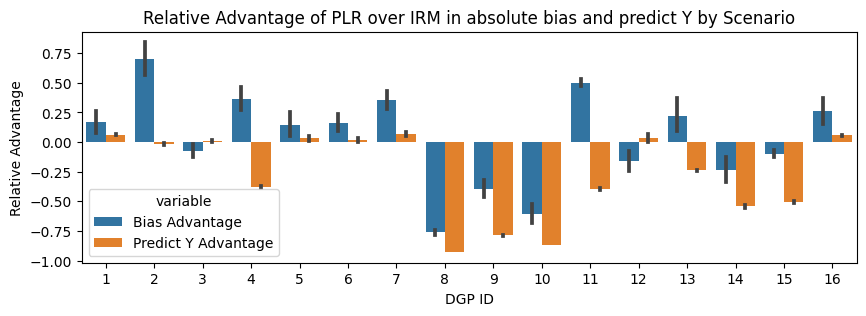

In [22]:
plt.figure(figsize=(10,3))
sns.barplot(data=cm_df2.melt(id_vars=["sc","rep"]), x='sc', y='value', hue='variable')
plt.ylabel("Relative Advantage")
plt.title("Relative Advantage of PLR over IRM in absolute bias and predict Y by Scenario")
plt.xlabel("DGP ID")

## Triple Plots, Fig 27-34

In [ ]:
df_temp = pd.concat((df.loc[(df.model=="irm") & (df.scheme=="fullsample")],default_df.loc[default_df.model=="plr"]))
for scid in [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]:
    fig, axs = plt.subplots(4,3, figsize=(13,18)) # 10,20 orig
    axs.flatten()
    for i in range(4):
        sns.barplot(df_temp.loc[df_temp.sc==scid[i]], y="rrmse-1", x="learner", ax=axs[i][0])
        sns.boxplot(df_temp.loc[df_temp.sc==scid[i]], y="bias", x="learner", ax=axs[i][1], showfliers = False)
        sns.boxplot(df_temp.loc[df_temp.sc==scid[i]], y="comb_loss", x="learner", ax=axs[i][2], showfliers = False)
        axs[i][0].set_title(f"Scenario {scid[i]}, rRMSE - 1")
        axs[i][0].set_ylabel("rRMSE - 1")
        axs[i][1].set_ylabel("Bias")
        axs[i][2].set_ylabel("Combined Loss")
        axs[i][1].set_title(f"Scenario {scid[i]}, Bias")
        axs[i][2].set_title(f"Scenario {scid[i]}, Combined Loss")
        axs[i][0].set_xticklabels(axs[i][0].get_xticklabels(), rotation=45, ha='right')
        axs[i][1].set_xticklabels(axs[i][1].get_xticklabels(), rotation=45, ha='right')
        axs[i][2].set_xticklabels(axs[i][2].get_xticklabels(), rotation=45, ha='right')
        axs[i][0].set_xlabel("Learner")
        axs[i][1].set_xlabel("Learner")
        axs[i][2].set_xlabel("Learner")
    fig.suptitle("Causal MSE vs. Combined Loss, IRM, Fullsample") 
    fig.tight_layout()
    fig.subplots_adjust(top=0.96)
    plt.show()

## Fig 7: Learners

In [31]:
grouped_df1 = df.loc[(df.scheme=="fullsample")].groupby(['sc', 'rep', 'model']).agg({'predict_y': 'median'}).reset_index()
idx = grouped_df1.groupby(['sc', 'rep'])['predict_y'].idxmin()
filtered_df1 = grouped_df1.loc[idx].drop(columns=["predict_y"])
df_new = filtered_df1.merge(df.loc[(df.scheme=="fullsample")], on=['sc', 'rep',"model"], validate="one_to_many")
df_def_new = filtered_df1.merge(default_df, on=['sc', 'rep',"model"], validate="one_to_many")

In [32]:
grouped_df1 = df.loc[(df.scheme=="fullsample")].groupby(['sc', 'rep', 'model']).agg({'predict_y': 'median'}).reset_index()
idx = grouped_df1.groupby(['sc', 'rep'])['predict_y'].idxmin()
filtered_df1 = grouped_df1.loc[idx]
filtered_df1 = filtered_df1.merge(df, on=["sc","rep","model"], validate="one_to_many")
grouped_df2 = filtered_df1.groupby(['sc', 'rep', 'learner', 'scheme','model']).agg({'comb_loss': 'min'}).reset_index()
idx = grouped_df2.groupby(['sc', 'rep'])['comb_loss'].idxmin()
filtered_df2 = grouped_df2.loc[idx]
final_df = pd.merge(filtered_df2.drop(columns=["comb_loss"]), df, on=["sc", "rep", "model", "scheme", "learner"], how="left", validate="one_to_one")

res = []
for sc in scenarios:
    true_theta = oracle_df.loc[oracle_df.DGPid==(sc+1),"psi0.ATE"].values[0]
    oracle_mse = oracle_df.loc[oracle_df.DGPid==(sc+1),"MSE"].values[0]
    sub_df = final_df.loc[final_df.sc==(sc+1)]
    bias = sub_df.coef - true_theta
    res.append(pd.DataFrame([np.repeat(np.sqrt(np.mean(np.square(bias)))/np.sqrt(oracle_mse),100).T, bias],  index=["rrmse","bias"]).T)
res_combloss = pd.concat(res)

In [33]:
grouped_df1 = df.loc[(df.scheme=="fullsample")].groupby(['sc', 'rep', 'model']).agg({'predict_y': 'median'}).reset_index()
idx = grouped_df1.groupby(['sc', 'rep'])['predict_y'].idxmin()
filtered_df1 = grouped_df1.loc[idx]
filtered_df1 = filtered_df1.drop(columns=["predict_y"]).merge(df, on=["sc","rep","model"], validate="one_to_many")
grouped_df2 = filtered_df1.groupby(['sc', 'rep', 'learner', 'scheme','model']).agg({'predict_y': 'min'}).reset_index()
idx = grouped_df2.groupby(['sc', 'rep'])['predict_y'].idxmin()
filtered_df2 = grouped_df2.loc[idx]
final_df = pd.merge(filtered_df2.drop(columns=["predict_y"]), df, on=["sc", "rep", "model", "scheme", "learner"], how="left", validate="one_to_one")

res = []
for sc in scenarios:
    true_theta = oracle_df.loc[oracle_df.DGPid==(sc+1),"psi0.ATE"].values[0]
    oracle_mse = oracle_df.loc[oracle_df.DGPid==(sc+1),"MSE"].values[0]
    sub_df = final_df.loc[final_df.sc==(sc+1)]
    bias = sub_df.coef - true_theta
    res.append(pd.DataFrame([np.repeat(np.sqrt(np.mean(np.square(bias)))/np.sqrt(oracle_mse),100).T, bias],  index=["rrmse","bias"]).T)
res_pred_y = pd.concat(res)

In [34]:
grouped_df1 = df.loc[(df.scheme=="fullsample")].groupby(['sc', 'rep', 'model']).agg({'predict_y': 'median'}).reset_index()
idx = grouped_df1.groupby(['sc', 'rep'])['predict_y'].idxmin()
filtered_df1 = grouped_df1.loc[idx].drop(columns=["predict_y"])
final_df = pd.merge(filtered_df1, df.loc[df.scheme=="fullsample"], on=["sc", "rep", "model"], how="left")
final_df2 = final_df.groupby(["sc","rep"])["coef"].mean().reset_index()

res = []
for sc in scenarios:
    true_theta = oracle_df.loc[oracle_df.DGPid==(sc+1),"psi0.ATE"].values[0]
    oracle_mse = oracle_df.loc[oracle_df.DGPid==(sc+1),"MSE"].values[0]
    sub_df = final_df2.loc[final_df2.sc==(sc+1)]
    bias = sub_df.coef - true_theta
    res.append(pd.DataFrame([np.repeat(np.sqrt(np.mean(np.square(bias)))/np.sqrt(oracle_mse),100).T, bias],  index=["rrmse","bias"]).T)
res_stack = pd.concat(res)

In [35]:
for sc in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
    for learner in df_new.learner.unique():
        coefs = df_new.loc[(df_new.learner == learner) & (df_new.sc==sc), "coef"]
        true_theta = oracle_df.loc[oracle_df.DGPid==sc,"psi0.ATE"].values[0]
        oracle_mse = oracle_df.loc[oracle_df.DGPid==sc,"MSE"].values[0]
        rrmses = np.sqrt(np.mean(np.square(coefs - true_theta))) / np.sqrt(oracle_mse)
        df_new.loc[(df_new.learner == learner) & (df_new.sc==sc), "rrmse"] = rrmses

In [36]:
plot_df = pd.concat((res_combloss,
            res_stack,
            res_pred_y,
            df_new.loc[df_new.learner=="FLAML",["rrmse","bias"]],
            df_new.loc[df_new.learner=="Lasso",["rrmse","bias"]],
            df_new.loc[df_new.learner=="XGBoost",["rrmse","bias"]],
            df_new.loc[df_new.learner=="Random Forest",["rrmse","bias"]],
            df_new.loc[df_new.learner=="LinearModels",["rrmse","bias"]]), keys=["Combined Loss", "Stack", "Predict Y", "FLAML", "Lasso", "XGBoost", "Random Forest", "Linear"]).reset_index()

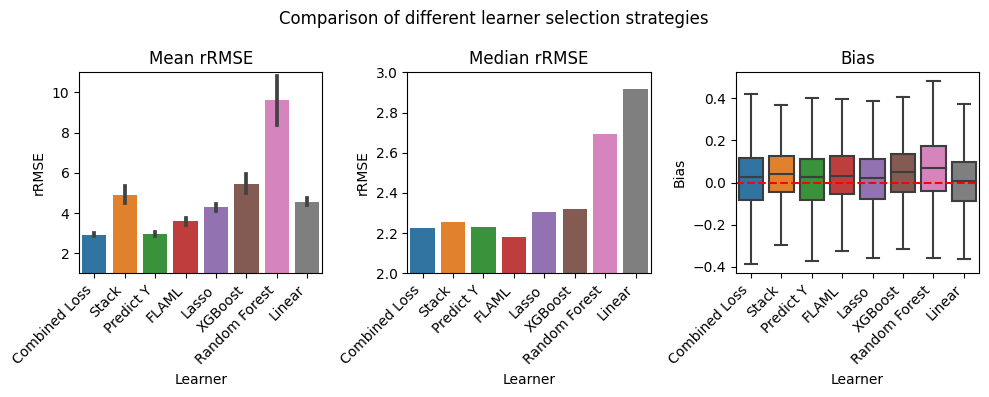

In [37]:
fig, axs = plt.subplots(1,3, figsize=(10,4))
axs.flatten()
sns.barplot(plot_df, x="level_0", y="rrmse", ax=axs[0])
sns.barplot(plot_df, x="level_0", y="rrmse", errorbar=None, estimator="median", ax=axs[1])
sns.boxplot(plot_df, x="level_0", y="bias", ax=axs[2], showfliers = False)
axs[2].axhline(y=0, color="r", linestyle="--")
axs[0].set_title("Mean rRMSE")
axs[0].set_xlabel("Learner")
axs[0].set_ylabel("rRMSE")
axs[0].set_ylim(1,11)
axs[1].set_ylim(2,3)
axs[1].set_title("Median rRMSE")
axs[1].set_xlabel("Learner")
axs[1].set_ylabel("rRMSE")
axs[2].set_title("Bias")
axs[2].set_xlabel("Learner")
axs[2].set_ylabel("Bias")
axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=45, ha='right')
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=45, ha='right')
axs[2].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=45, ha='right')
fig.suptitle("Comparison of different learner selection strategies")
fig.tight_layout()

## Figures for Linear Sims

In [48]:
learners = ["LassoCV", "XGBoost"]
schemes = ["fullsample", "splitsample", "onfolds", "default"]
sample_sizes = [20, 50, 100, 250, 500, 1000, 2000, 5000, 10000, 200000]
res = []
for n in sample_sizes:
    for learner in learners:
        for scheme in schemes:
            path = f"simulations/results/BCH/{learner}/{n}_{scheme}.csv"
            load_df = pd.read_csv(path)
            rep = load_df["Unnamed: 0"]
            bias = load_df["coef"].values - 0.5
            fs_loss_mll = load_df["fs_loss_mll"].values
            fs_loss_mlm = load_df["fs_loss_mlm"].values
            combined_loss = ((load_df["fs_loss_mll"] + load_df["fs_loss_mlm"]) * load_df["fs_loss_mlm"]).values
            dictionary = {"n": np.repeat(n,100),
                        "learner": np.repeat(learner,100),
                        "scheme": np.repeat(scheme,100),
                        "bias": bias,
                        "comb_loss": combined_loss,
                        "fs_loss_mll": fs_loss_mll,
                        "fs_loss_mlm": fs_loss_mlm,
                        "rep": rep}
            res.append(pd.DataFrame(dictionary))
df = pd.concat(res)

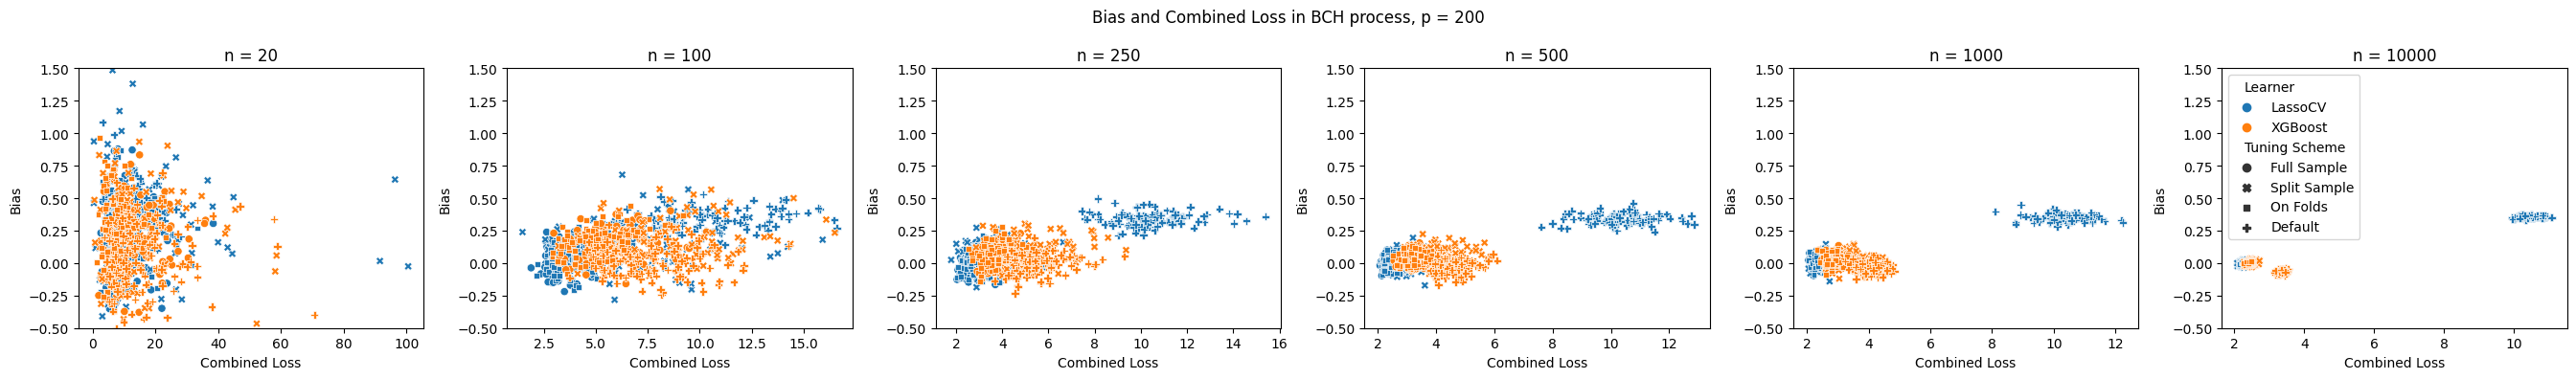

In [47]:
df["abs_bias"] = df.bias.abs()
df["Learner"] = df.learner
df.loc[df.scheme=="fullsample", "Tuning Scheme"] = "Full Sample"
df.loc[df.scheme=="splitsample", "Tuning Scheme"] = "Split Sample"
df.loc[df.scheme=="onfolds", "Tuning Scheme"] = "On Folds"
df.loc[df.scheme=="default", "Tuning Scheme"] = "Default"
fig, axs = plt.subplots(1,6, figsize=(27,4))
sample_sizes= [20,100,250,500,1000,10000]
for idx, ax in enumerate(fig.axes):
    if (idx == 5):
        sns.scatterplot(df.loc[df.n==sample_sizes[idx]], y="bias", x="comb_loss", hue="Learner", style="Tuning Scheme", ax=ax)
    sns.scatterplot(df.loc[df.n==sample_sizes[idx]], y="bias", x="comb_loss", hue="Learner", style="Tuning Scheme", ax=ax, legend=False)
    ax.set_title(f"n = {sample_sizes[idx]}")
    ax.set_ylim(-0.5,1.5)
    ax.set_ylabel("Bias")
    ax.set_xlabel("Combined Loss")
fig.suptitle("Bias and Combined Loss in BCH process, p = 200")
fig.tight_layout()
